<a href="https://colab.research.google.com/github/AliGhadirii/Covid19-Sentiment/blob/main/SentimentV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.0.0


     |████████████████████████████████| 757kB 29.5MB/s 
     |████████████████████████████████| 1.2MB 49.9MB/s 
     |████████████████████████████████| 890kB 56.3MB/s 
     |████████████████████████████████| 3.0MB 54.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=fc12a052767d994f3489f3e276b9914eeaa84a9a3c975bf73b01042e85224248
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

# specify GPU
device = torch.device("cuda")


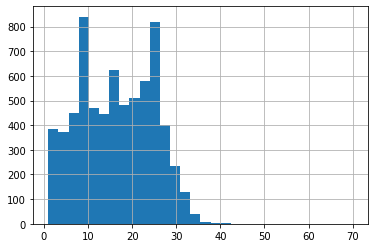

In [3]:
df = pd.read_csv("cleaned_data.csv")

train_text, temp_text, train_labels, temp_labels = train_test_split(df['full_text'], df['Sentiment_Label'], 
                                                                    random_state=2021, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Sentiment_Label'])

# we will use temp_text and temp_labels to create validation and test set, 50% each
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                    random_state=2021, 
                                                                    test_size=0.5, 
                                                                    stratify=temp_labels)

seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [4]:
max_seq_len = 25

In [5]:
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [6]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [7]:
bert = AutoModel.from_pretrained('bert-large-uncased')

for param in bert.parameters():
    param.requires_grad = False

In [8]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()
    
      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(1024,512)
      # dense layer 2
      self.fc2 = nn.Linear(512,256)
      # dense layer 3
      self.fc3 = nn.Linear(256,128)
      # dense layer 4
      self.fc4 = nn.Linear(128,64)
      # dense layer 5 (Output layer)
      self.fc5 = nn.Linear(64,3)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc2(x)

      x = self.relu(x)

      x = self.dropout(x)
      x = self.fc3(x)

      x = self.relu(x)

      x = self.dropout(x)
      x = self.fc4(x)

      x = self.relu(x)

      x = self.dropout(x)
      # output layer
      x = self.fc5(x)

      return x

In [10]:
model = BERT_Arch(bert)

#push the model to GPU
model = model.to(device)

optimizer = AdamW(model.parameters(), lr = 1e-3)


class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)
#convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

#loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights).to(device)

In [11]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [12]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [13]:
# number of training epochs
epochs = 10
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   200  of    213.

Evaluating...

Training Loss: 1.101
Validation Loss: 1.099

 Epoch 2 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   200  of    213.

Evaluating...

Training Loss: 1.097
Validation Loss: 1.095

 Epoch 3 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   200  of    213.

Evaluating...

Training Loss: 1.095
Validation Loss: 1.098

 Epoch 4 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   200  of    213.

Evaluating...

Training Loss: 1.094
Validation Loss: 1.090

 Epoch 5 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   200  of    213.

Evaluating...

Training Loss: 1.091
Validation Loss: 1.086

 Epoch 6 / 10
  Batch    50  of    213.
  Batch   100  of    213.
  Batch   150  of    213.
  Batch   20

In [14]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       741
           1       0.36      0.07      0.12       458
           2       0.33      0.69      0.44       258

    accuracy                           0.52      1457
   macro avg       0.45      0.50      0.42      1457
weighted avg       0.51      0.52      0.47      1457

